In [141]:
#IMPORTING LIBRARIES
import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mathematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files
import scipy.signal as signal 
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull
from GP_functions1 import GP_train, GP_predict


In [142]:
# KEY PARAMETERS USED THROUGHOUT MODEL

a = 350 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = np.float64(200000000) # Budget in £ to build the wind farm, accounting for construction costs.
DistanceToShore = 15000 # m #distance of the wind farm from shore
TooCloseShore = 5000 # m # minimum distance the wind farm must be from shore
xCoordOnshoreSub = 0 # x coordinate of the onshore substation (y coordinate is -(DistanceToShore))

USDtoGBP = 1/1.351  
EURtoGBP = 1/1.19

IACableCostperMeter = 409.2*EURtoGBP
ExportCableCostperMeter = 833.625*EURtoGBP

CostperTurbineUSD = np.float64(3000000) # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = np.float64(65500) # GBP
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP

OffshoreSubstationCostperMW = np.float64(104000*EURtoGBP)
OnshoreSubstationCostperMW = np.float64(87250*EURtoGBP)
# Costs  associated with the purchase and installation of electrical substations as well as the buildings required for housing the staff and additional equipment required for the running of the wind farm.

ElectricityCostperkWh = 0.144 # 14.4 pence - £0.144
DiscountRate = 0.07 # 7%

TurbineRating = 2 #2MW

GravityBase = 409000*EURtoGBP*TurbineRating #409000euro/MW
Monopile = 551000*EURtoGBP*TurbineRating
Jacket = 665000*EURtoGBP*TurbineRating
TensionLeg = 1163000*EURtoGBP*TurbineRating

In [143]:
#READING IN BATHYMETRY DATA
data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'    
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [144]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.    
maxnodespertree = maximumturbinespertree # As above
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result
MinIACableCostPerTurbine = a*IACableCostperMeter
MinExportCableCost = TooCloseShore*ExportCableCostperMeter # minimum export cable cost with respect to the minimum distance the wind farm must be form shore
MinFoundationCostPerTurbine = GravityBase*TurbineRating

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine+MinIACableCostPerTurbine+MinFoundationCostPerTurbine # Total costs (excluding export cable and fixed costs)
nnturb = (budget-MinExportCableCost)/MinCostperTurbTot 
FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nnturb*TurbineRating # *2 due to 2MW turbines being used *0.4 for assuming 40% effciency
nturb = (budget-FixedCost-MinExportCableCost)/(MinCostperTurbTot) # Turbines possible with current budget
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3615.099925980903
Min area per turbine = 106088.11196359372 m^2
Min area = 3713083.91872578 m^2
Max number of turbines = 35
Max area = 272798002.19209814 m^2


In [145]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-0.5a,-0.5aroot3) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
        
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

[[    0.             0.        ]
 [  350.             0.        ]
 [  525.           303.10889132]
 [  175.           303.10889132]
 [ -175.           303.10889132]
 [ -350.             0.        ]
 [ -525.          -303.10889132]
 [ -175.          -303.10889132]
 [  175.          -303.10889132]
 [  525.          -303.10889132]
 [  700.             0.        ]
 [  875.           303.10889132]
 [ 1050.           606.21778265]
 [  700.           606.21778265]
 [  350.           606.21778265]
 [    0.           606.21778265]
 [ -350.           606.21778265]
 [ -525.           303.10889132]
 [ -700.             0.        ]
 [ -875.          -303.10889132]
 [-1050.          -606.21778265]
 [ -700.          -606.21778265]
 [ -350.          -606.21778265]
 [    0.          -606.21778265]
 [  350.          -606.21778265]
 [  700.          -606.21778265]
 [  875.          -303.10889132]
 [ 1050.             0.        ]
 [ 1225.           303.10889132]
 [ 1400.           606.21778265]
 [ 1575.  

In [146]:
# Shoreline implementation

XShoreLine = np.array([np.linspace(min(positionlist[:,0])-2500,max(positionlist[:,0])+2500,1000)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m # 1000 data points
YShoreLine = np.array([np.linspace(-DistanceToShore,-DistanceToShore,1000)]) #Creates y coordinates of shoreline at -(distance of the wind farm from the shore) # 1000 data points
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLine = np.transpose(YShoreLine) #transpose of y coordinates
TShoreLine = np.concatenate((TXShoreLine,TYShoreLine),axis=1) # Shoreline (x,y)

In [147]:
# Finds distance between substation and shore

def Substation_To_Shore_Connection(positionlist):
    
    OnshoreSubstation = [xCoordOnshoreSub,-DistanceToShore] # Determines fixed position of onshore substation
    ExportDistance = np.sqrt(((positionlist[0,0]-OnshoreSubstation[0])**2)+((positionlist[0,1]-OnshoreSubstation[1])**2)) # min Hypotenuse for distances between substations
    
    return OnshoreSubstation,ExportDistance

OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist) #Initially Executes algorithm

print(OnshoreSubstation)
print(np.shape(OnshoreSubstation))
print(ExportDistance)

[0, -15000]
(2,)
15000.0


In [148]:
# Pushes wind farm further out if the smallest distance between the shore and center of wind farm is too small
# Only used for the pre-optimised layout
#In terms of keeping it this way there are bounds on (minimize(targetfunction, initial guess, bounds,.....etc.) the optimization function

CloseTurbY = min(positionlist[:,1]) # y coordinate of closest turbine
CloseTurbYindex = np.argmin(positionlist[:,1]) # index from closest turbine on y axis
CloseTurbX = positionlist[CloseTurbYindex,0] # x coordinate of closest turbine on y axis
DistanceToMinTurb = min(np.sqrt((CloseTurbX-TXShoreLine[:,0])**2+(CloseTurbY-TYShoreLine[:,0])**2)) #min distance from shore to closest turbine 
s = 0

if DistanceToMinTurb < TooCloseShore: # if closest turbine is too close to the shore
    for s in range(0,nturb+1): # loops for number of turbines plus the substation
        positionlist[s,1] = positionlist[s,1] + (TooCloseShore-DistanceToMinTurb)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required
    Substation_To_Shore_Connection(positionlist) #Calls function to redo substation to shore connection with new values

(-16606.217782649106, -706.217782649107)

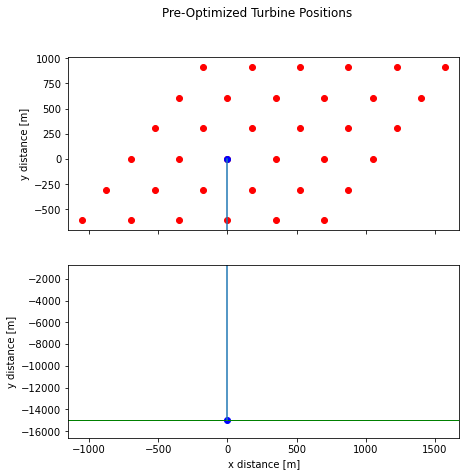

In [149]:
# Display pre-optimized turbine positions before clustering and MST

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)    
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

In [150]:
#Function to determine land cost of wind farm using a convex hull
#Calcualtes area of wind farm, onshore substation, and export cable
#Won't work for just 1 turbine since no boundary to enclose

def LandAreaCost(positionlist,ExportDistance):
    
    radius = 130 #m
    OnshoreSubLand = np.pi*radius**2 #Land area associated with the onshore substation
    ExportLand = ExportDistance*8 # Length*width 
    
    hull = ConvexHull(positionlist) #computes convex hull using the turbine positions
    LandArea = hull.volume + OnshoreSubLand + ExportLand #Calcualtes convex hull area and adds on the onshore substation land area

    LandCost = LandArea*LandCostpermSquared
    
    return LandCost

LandCost = LandAreaCost(positionlist,ExportDistance)

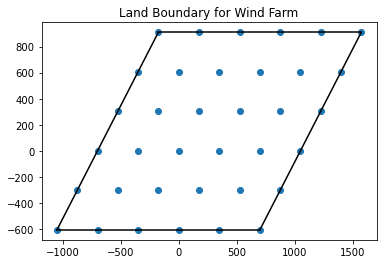

In [151]:
#Visual aid for convex hull plotting

hull = ConvexHull(positionlist)
plt.plot(positionlist[:,0], positionlist[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(positionlist[simplex, 0], positionlist[simplex, 1], 'k-')


plt.title('Land Boundary for Wind Farm')
plt.show()

 C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:Spaces are not permitted in the name. Converted to '_'


Function run time: 0.7592730000033043
[[   0   11   12   13   28   29   30   31   32 -100 -100]
 [   0    5    6    7   17   18   19   20   21   22 -100]
 [   0    1    8    9   10   23   24   25   26   27 -100]
 [   0    2    3    4   14   15   16   33   34   35 -100]]


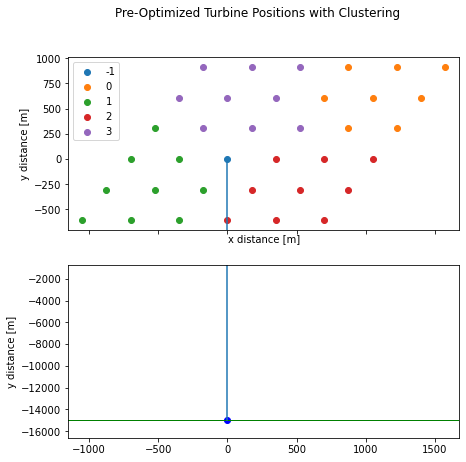

In [152]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustering')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
for i in u_labels: # loops for number of turbines
    ax1.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax1.legend() # prints legend
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

print(indiceslist)

In [153]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

#distance_global - distances of each turbine with respect to the substation and each other h=sqrt(x^2+y^2)
#e.g. row 0 would be each turbines distance with respect to the substation
# and row 4 would be each turbines distance with respect to the 4th turbine as found in the position list
# distance_globl[i,i] = 1e10 since this is the distance of each turbine with respect to itself so we want the MST to ignore thse values
#angle_global - angle of each turbine with respect to the substation and each other arctan(y/x)
#distance and angle then do something similar but considering the cluster formations as well

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1) # Everything except the -100 ones which were denoted earlier to show that there is no turbine at that index
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [154]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()
    return MSTweight

Each tree weight tree 1 3376012.958872607
Each tree weight tree 2 3150000.0
Each tree weight tree 3 3150000.0
Each tree weight tree 4 3150000.0
MST total weight 12826012.958872607 m


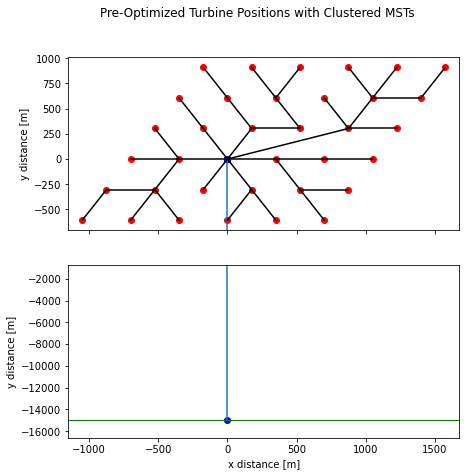

In [155]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustered MSTs')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax1.plot(u,v, c='black')
        ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [156]:
#DISPLAYS RAW BATHYMETRY DATA

#print(data) # Prints out bathymetry data - Read in using pandas in previous section

In [157]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

#print(data) 

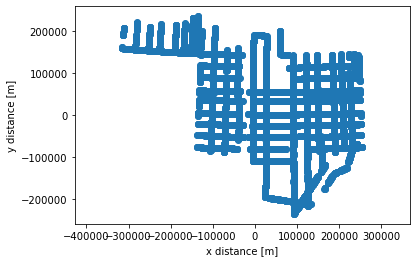

In [158]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

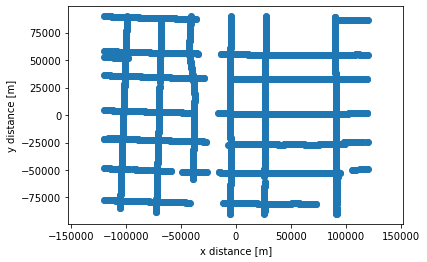

In [159]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

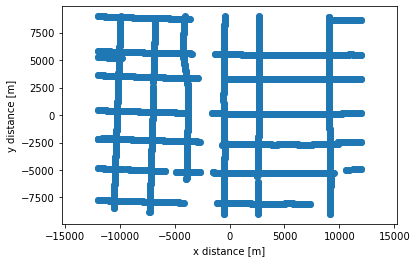

In [160]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

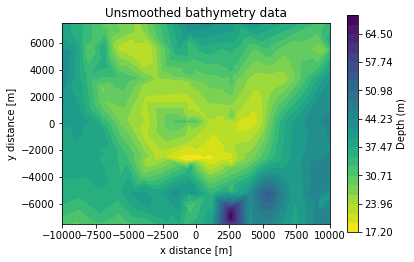

In [161]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

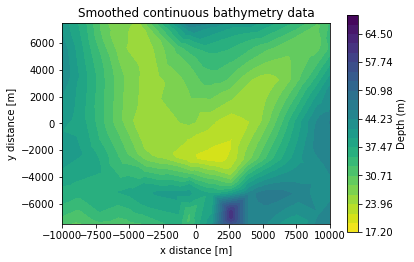

In [162]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [163]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = np.float64(0) # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(5634628.501841279, 23.394764925387133, 27.392063228618998)

In [164]:
smooth

In [165]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=10. #[degrees]

In [166]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [167]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=10 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [168]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


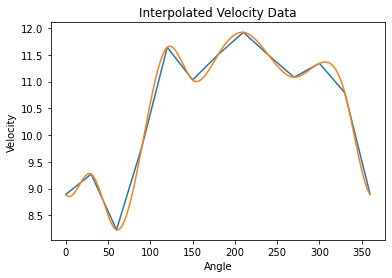

In [169]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

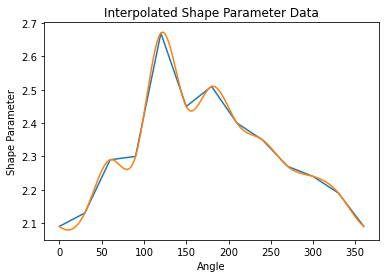

In [170]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

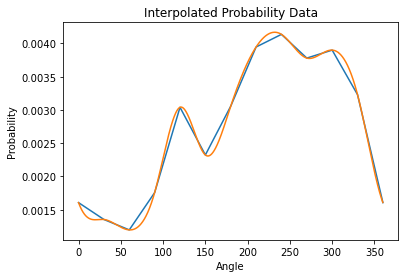

In [171]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [172]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

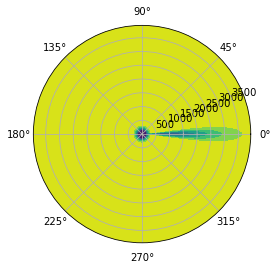

0.580003843


In [173]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [174]:
# # isn't useful for continuing code, just rotates the windfarm.
# def rotate(angle,coords):
#     angle = np.pi*angle/180.
#     rotcoordx = []
#     rotcoordy = []
#     for coord in coords:
#         rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
#         rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
#     rotcoords=[rotcoordx,rotcoordy]
#     rotcoords=np.array(rotcoords).T   
#     return rotcoords 
# #print rotate(254,coords)[:,0]
# plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [175]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [176]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [177]:
## (USED IN TARGET FUNC)
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [178]:
## GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [179]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [180]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [181]:
wind_dist(1.0,v0)

0.024244336764100854

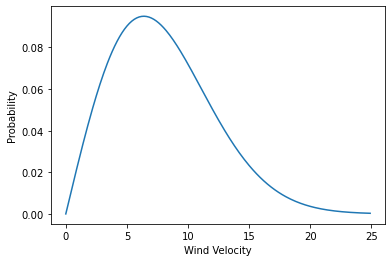

In [182]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [183]:
velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)
print(angles)
print(velocities)
print(dang)

[[1.59060699e-03 1.96007335e-03 2.11578542e-03 2.06554235e-03
  1.85291694e-03 1.54105749e-03 1.19479128e-03 8.66572938e-04
  5.89367030e-04 3.76482579e-04 2.26143272e-04 1.27838162e-04
  6.80507775e-05 3.41260914e-05]
 [1.37464016e-03 1.68898272e-03 1.82058815e-03 1.77722757e-03
  1.59622896e-03 1.33092166e-03 1.03584993e-03 7.55222381e-04
  5.17050884e-04 3.32968001e-04 2.01931271e-04 1.15428809e-04
  6.22315962e-05 3.16590019e-05]
 [1.26305751e-03 1.57069550e-03 1.71589133e-03 1.70031589e-03
  1.55286799e-03 1.31888363e-03 1.04744447e-03 7.80641049e-04
  5.47277027e-04 3.61509466e-04 2.25268024e-04 1.32529849e-04
  7.36593076e-05 3.86931180e-05]
 [1.22462363e-03 1.54869431e-03 1.71501338e-03 1.71844992e-03
  1.58340741e-03 1.35377058e-03 1.07981334e-03 8.06301042e-04
  5.64900466e-04 3.71904803e-04 2.30316031e-04 1.34261882e-04
  7.37090423e-05 3.81206146e-05]
 [1.23090149e-03 1.57784680e-03 1.75269447e-03 1.74493210e-03
  1.58254019e-03 1.31906138e-03 1.01561016e-03 7.24558330e-04


In [184]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

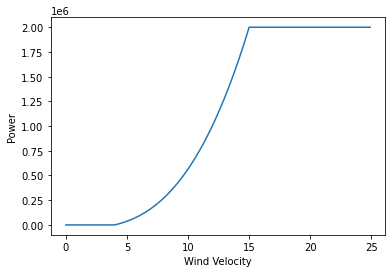

In [185]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [186]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

In [187]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[867164.86359585 867164.86359585 867164.86359585 867164.86359585
 867164.86359585 867164.86359585 867164.86359585 867164.86359585
 867164.86359585 867164.86359585 867164.86359585 867164.86359585
 867164.86359585 867164.86359585 867164.86359585 867164.86359585
 867164.86359585 867164.86359585 867164.86359585 867164.86359585
 867164.86359585 867164.86359585 867164.86359585 867164.86359585
 867164.86359585 867164.86359585 867164.86359585 867164.86359585
 867164.86359585 867164.86359585 867164.86359585 867164.86359585
 867164.86359585 867164.86359585 867164.86359585] (35,) 30350770.225854658


In [188]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [189]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [190]:
## IMPORTING WIND DIRECTION DATA
## north = 0 degrees
direction_data = pd.read_csv('Directiondata.csv')
wind_directions = directiondata['Angle']
wind_directions = pd.DataFrame(wind_directions).to_numpy()
wind_directions = np.transpose(wind_directions)

In [191]:
# FUNCTION: SIMPLE ROTATE
def rotate(angle,coords):
    angle = np.pi*angle/180.
    rotcoordx = []
    rotcoordy = []
    for coord in coords:
        rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
        rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
    rotcoords=[rotcoordx,rotcoordy]
    rotcoords=np.array(rotcoords).T
    return rotcoords

In [192]:
# TRAIN MODEL and assign to predicting class
name = "all_dataset.csv"
training_class = GP_train() # create training class
training_model = training_class.train_model() # trains model on "all_dataset.csv"

# CREATE PREDICTING CLASS from which attenuation predictions are made
predict_class = GP_predict(training_model) # create predicting class

In [193]:
## OLD WINDSPEED REDUCTION FUNCTION (USED IN TARGET FUNC)
## description: calculates the % of wind that arrives at a turbine for a certain angle.
## Starts with assumption that there's zero wake so all turbines get full wind.
def windspeedreduction_old(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.
    
## TESTING   
distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist)
print(f'OLD WSR')
print(f'positionlist.shape = {positionlist.shape}')

print(f'angles.shape = {angles.shape}     (number of wind angles!)')
wsr=windspeedreduction_old(distance_global,angle_global,angles,model) ## old WSR function
# np.set_printoptions(threshold=np.inf)
# print(f'wsr = \n{wsr}')
# np.set_printoptions(threshold=1000)
print(f'type(wsr) = {type(wsr)}\nwsr.shape = {wsr.shape}\nCONCLUSION: the first dimension (y = {wsr.shape[0]}) is nturb, the second dimension (x = {wsr.shape[1]}) is ndir')

OLD WSR
positionlist.shape = (36, 2)
angles.shape = (36,)     (number of wind angles!)
type(wsr) = <class 'numpy.ndarray'>
wsr.shape = (35, 36)
CONCLUSION: the first dimension (y = 35) is nturb, the second dimension (x = 36) is ndir


In [194]:
## FUNCTION: WIND SPEED REDUCTION (WSR) (NEW!)
## description: returns a matrix of wind attenuation with nturb turbine rows, ndir direction columns
def windspeedreduction(positionlist,directions,g_model):
    ndir = int(np.size(directions))
    nturb = int(np.size(positionlist)/2)
    total_att=np.ones((nturb,ndir))
    for i in range(0,ndir):
        angle_to_rotate = 90 + directions[i];
        westerly_pos_list = rotate(angle_to_rotate,positionlist) # rotate position list for westerly wind
        att_vector = g_model.predict(westerly_pos_list, nturb) # vector of attenuations (from GP_functions module)
        att_vector = att_vector.reshape(nturb,)
#         print(f'positionlist.shape = {positionlist.shape}')
#         print(f'ndir = {ndir}')
#         print(f'att_vector.shape = {att_vector.shape}')
#         print(f'total_att.shape = {total_att.shape}')
#         print(f'total_att[:,i].shape = {total_att[:,i].shape}')
        total_att[:,i] = att_vector
#         if i == 0:
#             total_att = att_vector
#         total_att = np.vstack((total_att,att_vector))
        
    total_att = total_att/8 ## Get attenuation as a fraction compared to the assumed base wind speed in gaussian model of 8 m/s
    return total_att

## TESTING
wind_directions_for_WSR = wind_directions[0]
print('NEW WSR')
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
print(f'positionlist.shape = {positionlist.shape}')
print(f'wind_directions_for_WSR.shape = {wind_directions_for_WSR.shape}     (number of wind angles!)')
print(f'type(wsr) = {type(wsr)}\nwsr.shape = {wsr.shape}\nCONCLUSION: the first dimension (y = {wsr.shape[0]}) is nturb, the second dimension (x = {wsr.shape[1]}) is ndir')

NEW WSR


 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos


positionlist.shape = (36, 2)
wind_directions_for_WSR.shape = (13,)     (number of wind angles!)
type(wsr) = <class 'numpy.ndarray'>
wsr.shape = (35, 36)
CONCLUSION: the first dimension (y = 35) is nturb, the second dimension (x = 36) is ndir


In [195]:
powout=power(wsr,velocities); # total output power
output=np.tensordot(powout,wsp,axes=2);

 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


In [196]:
def foundationDepthCost(foundation,DepthPerTurbine):
    
    FoundationCost = foundation*(0.0002*(float(DepthPerTurbine)**2) - 0.0002*(float(DepthPerTurbine)) + 0.9459)
    
    return FoundationCost

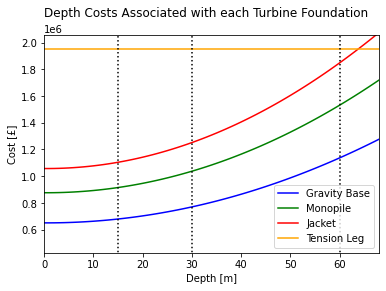

In [197]:
# Plots depth functions for each individual turbine foundation type

Depthx = range(0,math.ceil((max(data['CORR_DEPTH']))),1)
GBCost = [None] * len(Depthx)
MPCost = [None] * len(Depthx)
JCost = [None] * len(Depthx)
TLCost = [None] * len(Depthx)
Depth = 0

for i in Depthx:
    GBCost[i] = foundationDepthCost(GravityBase,Depth)
    MPCost[i] = foundationDepthCost(Monopile,Depth)
    JCost[i] = foundationDepthCost(Jacket,Depth)
    TLCost[i] = TensionLeg
    Depth += 1
    
fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with each Turbine Foundation')

x1 = np.linspace(15,15,100)
x2 = np.linspace(30,30,100)
x3 = np.linspace(60,60,100)
y = np.linspace(0,TensionLeg+500000,100)

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx,GBCost,'blue')
ax.plot(Depthx,MPCost,'green')
ax.plot(Depthx,JCost,'red')
ax.plot(Depthx,TLCost,'orange')
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

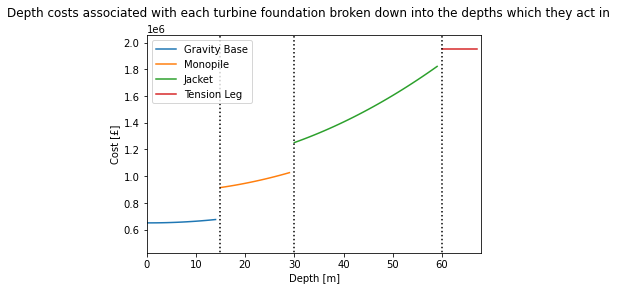

In [198]:
# Plots depth functions for each individual turbine foundation type but only considers the depths for which the foundation will act in

GBCost2 = GBCost[Depthx[0]:Depthx[15]]
MPCost2 = MPCost[Depthx[15]:Depthx[30]]
JCost2 = JCost[Depthx[30]:Depthx[60]]
TLCost2 = TLCost[Depthx[60]:max(Depthx)]

fig, ax = plt.subplots()
fig.suptitle('Depth costs associated with each turbine foundation broken down into the depths which they act in')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:15],GBCost2)
ax.plot(Depthx[15:30],MPCost2)
ax.plot(Depthx[30:60],JCost2)
ax.plot(Depthx[60:max(Depthx)],TLCost2)
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

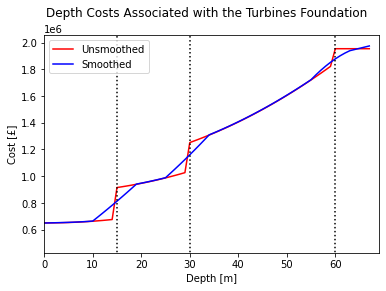

In [199]:
# Combines all the indivdual depths costs over there used depths into one plot and smooths the data

GBMPJTL = GBCost2+MPCost2+JCost2+TLCost2

fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with the Turbines Foundation')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH'])))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:max(Depthx)],GBMPJTL,color='r')
smoothed_2dg = savgol_filter(GBMPJTL, window_length = 9, polyorder = 1)
ax.plot(Depthx[0:max(Depthx)], smoothed_2dg, color='b')
plt.legend(['Unsmoothed','Smoothed'])
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')

In [200]:
def foundations(positionlist):
    
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    FoundationCost = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    FoundationCostTotal = 0 # Assigns initial value to variable
    
    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1])
        
        FoundationCost[i] = np.interp(DepthPerTurbine[i],Depthx[0:max(Depthx)],smoothed_2dg)

        FoundationCostTotal += FoundationCost[i]
        
    return FoundationCostTotal

FoundationCostTotal = foundations(positionlist)

In [201]:
# Function for calculated payback time, discounted payback time, Net Present Value, and Profitability Index

def Payback(TPO,TotalCost,positionlist):
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation at positonlist[0,:]
    
    CashFlowYearly = (ElectricityCostperkWh*24*365*(TPO/1000))-(OperatingandMaintenanceCostsperAnnum*nturb) # Calculates the yaerly cash flow for the windfarm
    PayBackTime = TotalCost/CashFlowYearly # calculates payback time in years
    DiscountedPayBackTime = (np.log(1/(1-((TotalCost*DiscountRate)/CashFlowYearly))))/np.log(1+DiscountRate) #Calculates payback time but takes into account the time value of money
    
    l=0
    NPV = 0
    
    for l in range(LifeTimeTurbineOperatingTime):
        l+=1
        NPV = NPV + (CashFlowYearly)/((1+DiscountRate)**l) #NPV is a method used to determine the current value of future cash flows generated by the project
    
    NPV = NPV - TotalCost
    ProfIndex = (NPV+TotalCost)/TotalCost # Probability index >1 it's profitable <1 its not
    
    return PayBackTime,DiscountedPayBackTime,NPV,ProfIndex

In [202]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance):
    
    mindepth = depthvalues(positionlist)[1]
    maxdepth = depthvalues(positionlist)[2]
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
    fig.suptitle('Plot Showing Sea Floor Topography and Turbines with Cables')
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    ax1.set_ylabel('y distance [m]') # y axis label
    ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    ax2.set_xlabel('x distance [m]') # x axis label
    ax2.set_ylabel('y distance [m]') # y axis label
    ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits
    
    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            ax1.plot(u,v, c='black')
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine 
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal 

    print('\033[1m'+'Maximum turbines per MST:'+'\033[0m', maximumturbinespertree)
    print('\033[1m'+'Number of turbines:'+'\033[0m', nturb)
    print()
    print('\033[1m'+'Inter-Array Cabling Costs: £'+'\033[0m', CableCost)
    print('\033[1m'+'Export Cabling Costs: £'+'\033[0m', ExportCableCost)
    print('\033[1m'+'Depth Cost: £'+'\033[0m', DepthCostAll)
    print('\033[1m'+'Foundations Cost: £'+'\033[0m', FoundationCostTotal)
    print('\033[1m'+'Turbine Cost: £'+'\033[0m', TurbineCostTotal)
    print('\033[1m'+'Land Cost: £'+'\033[0m', LandCost)
    print('\033[1m'+'Maintenance Cost: £'+'\033[0m', MaintenanceCosts)
    print('\033[1m'+'Fixed Cost:'+'\033[0m', FixedCost)
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow
    
    fig.subplots_adjust(left=0.1, right=0.8) #Adjusts plots to be able to fit a single color bar across both plots
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    tcf = ax1.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8]) #Locates colorbar across both subplots
    cbar = plt.colorbar(tcf,cax=cb_ax) #plots colorbar with location as stated by cb_ax
    cbar.set_label('Depth (m)')    
    
    ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    tcf = ax2.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')

    ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
    ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
    ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    fig, ax3 = plt.subplots()
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs','(Export) Cabling Costs','Foundation Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost,ExportCableCost,FoundationCostTotal] # Figures for each segment of pie chart
    
    ax3.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax3.axis('equal') #equal aspect ratio
    ax3.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos
 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


PRE-OPTIMISED LAYOUT INFORMATION
Maximum turbines per MST: 10
Number of turbines: 35

Inter-Array Cabling Costs: £ 4410423.9519081265
Export Cabling Costs: £ 10507878.151260504
Depth Cost: £ 5634628.501841279
Foundations Cost: £ 35490725.1491578
Turbine Cost: £ 77720207.253886
Land Cost: £ 4872222.4604062885
Maintenance Cost: £ 45850000.0
Fixed Cost: 11250000.0

Budget: £ 200000000.0
Total Cost: £ 195736085.46846
Total Power Output: 17061036.497690093 W
Theoretical Max Total Power Output: 26386433.54493817 W
Percentage power lost to wake effcts: 35.341635054112906 %
Cost per Watt: 11.472696016737368 £/W

Payback Time: 10.179226759242002 years
Discounted Payback Time: 18.426202981722955 years
NPV: £ 7975937.739169806 over a  20 year period
Profitability Index: £ 1.0407484277622125 over a  20 year period


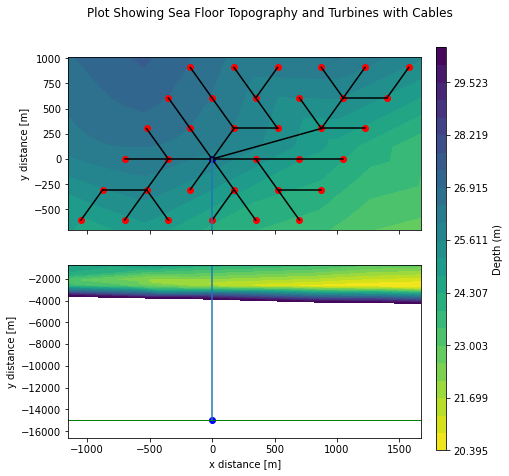

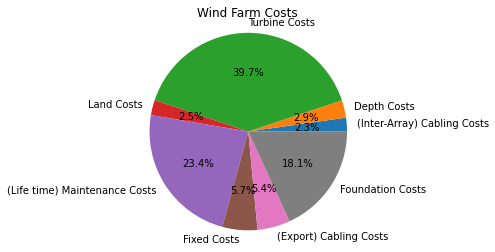

In [203]:
## PRE-OPTIMISED LAYOUT AND GAUSSIAN TESTING

# CALCULATES 
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

## Below calculates max theoreticl power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)


#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO

print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance)

PayBackTime,DiscountedPayBackTime,NPV,ProfIndex = Payback((np.sum(output)),TotalCost,positionlist)

print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(np.sum(output)/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt:'+'\033[0m',TotalCost/np.sum(output),'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [204]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION

overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

In [205]:
v=2
for amount in range(0,v):
    nturb = nturb - 1
    positionlist = np.delete(positionlist, len(positionlist)-1, 0)
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)

 C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:Spaces are not permitted in the name. Converted to '_'


In [206]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []
smallestExportDistance = None

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    global smallestExportDistance

    arr2=np.reshape(coord_flat,(-1,2)) # undoes the coordinate flattening
    hull = ConvexHull(arr2)
    arr1 = np.array([np.mean(hull.points[hull.vertices,0]),np.mean(hull.points[hull.vertices,1])])
    arr1 = np.reshape(arr1,(-1,2))
    positionlist = np.concatenate((arr1,arr2),axis=0)
    #positionlist = np.reshape(coord_flat,(-1,2))#np.concatenate((arr1,arr2),axis=0) #np.reshape(coord_flat,(-1,2))
    
    nturb=np.size(positionlist,0)-1 # determines number of turbines (-1 due to the substation)
    print('nturb', nturb)
    
    OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) # calls clustering function
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist) # calls pre-MST function
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist) # Calls MST function
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)): 
        MSTWeightSum += MSTweight[a][0] 
#     wsr=windspeedreduction(distance_global,angle_global,angles,model) ## old WSR function
    wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2) # reduced power output due to wake effects
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost= (MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal= (nturb)*CostperTurbine
    MaintenanceCosts= (nturb)*MaintenanceCostperTurbine
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost= TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal

    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
        smallestExportDistance = ExportDistance

    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [207]:
angles

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
       220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
       330., 340., 350.])

In [208]:
# OPTIMIZATION

#xright = 0
#xleft = 0
#yup = 0
#ydown = 0
#for xright in range(0,nturb+1):
 #   if positionlist[xright,0]>0:
  #      positionlist[xright,0] = positionlist[xright,0] + 250
#for xleft in range(0,nturb+1):
 #   if positionlist[xleft,0]<0:
  #      positionlist[xleft,0] = positionlist[xleft,0] - 250
#for yup in range(0,nturb+1):
 #   if positionlist[yup,1]>0:
  #      positionlist[yup,1] = positionlist[yup,1] + 250
#for ydown in range(0,nturb+1):
 #   if positionlist[ydown,1]<0:
  #      positionlist[ydown,1] = positionlist[ydown,1] - 250
        
        
t1_start = perf_counter() # timer starts

dvel=1.5
dang=10
velocities=np.arange(Vc,Vf,dvel)
angles=np.arange(0,360,dang)        
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.

while True:  
    
    iteration_time_start = perf_counter()
    
    #flat_coords=positionlist.flatten() # turns 2D coords into single list of data without any more structure.
    flat_coords=positionlist[1:,:].flatten() # turns 2D coords into single list of data without any more structure.
        
    # b = (Lower bound, Upper bound)
    b2 = ((min(positionlist[:,0]))-1000,(max(positionlist[:,0]))+1000) #bounds for x coordinates
    #b3 = ((OnshoreSubstation[1]+((TooCloseShore-2500))),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    b3 = (((min(positionlist[:,1]))-1000),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    bnd = (b2,b3) #bounds for x,y coordinates of each turbine 
    bnd1 = (bnd*(nturb)) #repeats bnd for the amount of turbines 
    bnds = bnd1 #Combines all bounds into a list for use in the optimization function
    
    #res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, bounds=bnds, options={'disp': 2, 'eps': 50, 'ftol': 1e-17, 'gtol': 1e-17})
    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, options={'disp': 2, 'eps': 50})#, 'ftol': 1e-17, 'gtol': 1e-17})

    #res = minimize(targetfunction, flat_coords, method='Nelder-Mead', jac=False, bounds=bnds, options={'disp': 2, 'xatol': 1e-3, 'fatol': 1e-3})#, 'ftol': 1e-17, 'gtol': 1e-17})
    #res = minimize(targetfunction, flat_coords, method='TNC', jac=False, bounds=bnds, options={'disp': 2, 'eps':50})#, 'ftol': 1e-17, 'gtol': 1e-17})
    
    iteration_time_end = perf_counter()
    print(iteration_time_end-iteration_time_start)
    
    if smallestTotalCost<=budget: #if under budget
        if not res.success:
            print(res.status, res.message) 
        else:
            break # Stops optimization when minimization is under budget after an iteration of 'minimize' 
    else: # over budget then removes a turbine and resets approrate varaibles 
        nturb = nturb - 1 
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        smallestExportDistance = None
        
        wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
        powout=power(wsr,velocities) # total output power
        outputs=np.tensordot(powout,wsp,axes=2)
        LowestPower = min(outputs)
        LowestPowerIndex = np.argmin(outputs)
        LowestPowerTurbine = positionlist[LowestPowerIndex+1,:]
        positionlist = np.delete(positionlist, LowestPowerIndex+1, 0) 

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
          
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 33


 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos
 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


Total power output in Watts 16385117.843470233 Total Cost in £ 185091379.86477894 £/W 11.296310568711668
smallest cost per watt 11.296310568711668
nturb 33
Total power output in Watts 16446154.660853518 Total Cost in £ 185068410.96730796 £/W 11.252989819427086
smallest cost per watt 11.252989819427086
nturb 33
Total power output in Watts 16472387.031910984 Total Cost in £ 185080750.5720966 £/W 11.235818476918407
smallest cost per watt 11.235818476918407
nturb 33
Total power output in Watts 16523536.348141791 Total Cost in £ 185103924.65432703 £/W 11.20244000765269
smallest cost per watt 11.20244000765269
nturb 33
Total power output in Watts 16510396.966675598 Total Cost in £ 185029692.9579139 £/W 11.20685912830417
smallest cost per watt 11.20244000765269
nturb 33
Total power output in Watts 16442311.597429236 Total Cost in £ 185078919.6517258 £/W 11.256259106576168
smallest cost per watt 11.20244000765269
nturb 33
Total power output in Watts 16489589.782501033 Total Cost in £ 185090299

Total power output in Watts 16458729.65618769 Total Cost in £ 185096142.96838832 £/W 11.246077117428142
smallest cost per watt 11.20244000765269
nturb 33
Total power output in Watts 16438802.8792323 Total Cost in £ 185265782.457817 £/W 11.270028834755939
smallest cost per watt 11.20244000765269
nturb 33
Total power output in Watts 16463772.900619797 Total Cost in £ 185093452.61538756 £/W 11.242468766586272
smallest cost per watt 11.20244000765269
nturb 33
Total power output in Watts 16416982.268364005 Total Cost in £ 185210825.80307567 £/W 11.281660829955468
smallest cost per watt 11.20244000765269
nturb 33
Total power output in Watts 16453595.359021585 Total Cost in £ 185069121.0750997 £/W 11.247944114149217
smallest cost per watt 11.20244000765269
nturb 33
Total power output in Watts 16440081.795483513 Total Cost in £ 185172897.69526735 £/W 11.263502213604486
smallest cost per watt 11.20244000765269
nturb 33
Total power output in Watts 16440035.078326775 Total Cost in £ 185204876.543

Total power output in Watts 17540461.444729973 Total Cost in £ 184975585.56390262 £/W 10.54565104497171
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17565249.209792197 Total Cost in £ 185036474.90786603 £/W 10.534235677380126
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17522184.49056173 Total Cost in £ 185007471.34121147 £/W 10.558470688450127
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17576617.061182737 Total Cost in £ 185052452.79100603 £/W 10.528331597989185
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17529386.980714664 Total Cost in £ 185039699.7833503 £/W 10.555970952488284
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17577791.124625858 Total Cost in £ 185035715.76368424 £/W 10.526676216129102
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17548901.589582093 Total Cost in £ 1850

Total power output in Watts 17565534.735158868 Total Cost in £ 185069805.00812054 £/W 10.535961916245455
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17583874.94215283 Total Cost in £ 185067565.6938215 £/W 10.524845422448351
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17593271.349701785 Total Cost in £ 185084566.72214732 £/W 10.5201905343934
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17583640.755890213 Total Cost in £ 185051348.03229022 £/W 10.52406328139417
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17622969.590592146 Total Cost in £ 185083652.66178644 £/W 10.502410034265257
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17555840.84197075 Total Cost in £ 185038695.47229704 £/W 10.540007575708081
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17589025.069343776 Total Cost in £ 1850668

Total power output in Watts 17568046.393009707 Total Cost in £ 185062360.8003084 £/W 10.534031881538311
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17592652.941340167 Total Cost in £ 185069107.0482984 £/W 10.519681577609765
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17575990.39524873 Total Cost in £ 185048880.7598744 £/W 10.528503748494206
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17601989.537121702 Total Cost in £ 185027133.70404857 £/W 10.511717059815071
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17606397.132891677 Total Cost in £ 185038382.9931171 £/W 10.509724482326632
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17617471.789299592 Total Cost in £ 185036838.48490033 £/W 10.503030213295816
smallest cost per watt 10.502232243967466
nturb 33
Total power output in Watts 17588016.458248362 Total Cost in £ 185037

Total power output in Watts 17583025.2881542 Total Cost in £ 185055841.72305173 £/W 10.524687230457722
smallest cost per watt 10.502202237472968
nturb 33
Total power output in Watts 17609931.792955387 Total Cost in £ 185181249.0534343 £/W 10.515727785357667
smallest cost per watt 10.502202237472968
nturb 33
Total power output in Watts 17592120.291377906 Total Cost in £ 185062871.24585 £/W 10.51964562432826
smallest cost per watt 10.502202237472968
nturb 33
Total power output in Watts 17558100.982787956 Total Cost in £ 185049958.31923518 £/W 10.53929229024471
smallest cost per watt 10.502202237472968
nturb 33
Total power output in Watts 17577194.85837847 Total Cost in £ 185068234.36963555 £/W 10.528883354867038
smallest cost per watt 10.502202237472968
nturb 33
Total power output in Watts 17606070.874006413 Total Cost in £ 185036104.20522705 £/W 10.509789806561223
smallest cost per watt 10.502202237472968
nturb 33
Total power output in Watts 17606623.55675762 Total Cost in £ 185106321.0

Total power output in Watts 17591677.835586473 Total Cost in £ 185100408.85087088 £/W 10.52204403586953
smallest cost per watt 10.501717639563536
nturb 33
Total power output in Watts 17540758.667713467 Total Cost in £ 185097108.6283708 £/W 10.552400391271059
smallest cost per watt 10.501717639563536
nturb 33
Total power output in Watts 17580396.569617067 Total Cost in £ 185223740.57749808 £/W 10.535811285258886
smallest cost per watt 10.501717639563536
nturb 33
Total power output in Watts 17569057.71542776 Total Cost in £ 185037334.28604954 £/W 10.532001048841929
smallest cost per watt 10.501717639563536
nturb 33
Total power output in Watts 17578725.58201686 Total Cost in £ 185144698.01634508 £/W 10.53231630202756
smallest cost per watt 10.501717639563536
nturb 33
Total power output in Watts 17569793.526489303 Total Cost in £ 184938514.1571594 £/W 10.525935542630862
smallest cost per watt 10.501717639563536
nturb 33
Total power output in Watts 17589239.07060843 Total Cost in £ 18515697

Total power output in Watts 17542415.116699696 Total Cost in £ 185023303.40038463 £/W 10.547196732578154
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17568033.177306127 Total Cost in £ 185243651.86551946 £/W 10.544359177600587
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17547264.634576846 Total Cost in £ 185024920.45142955 £/W 10.544373969652133
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17540461.693785086 Total Cost in £ 185043371.733018 £/W 10.549515455376088
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17565249.45756233 Total Cost in £ 185001266.8867263 £/W 10.532231115401443
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17522184.7652592 Total Cost in £ 185007620.85672745 £/W 10.558479055850242
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17576617.36466391 Total Cost in £ 18506150

Total power output in Watts 17594419.80682928 Total Cost in £ 185035285.82190126 £/W 10.516702900886777
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17593195.620224617 Total Cost in £ 185040250.94656998 £/W 10.517716902656
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17574808.95745481 Total Cost in £ 185031626.69630226 £/W 10.528229760233968
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17565129.534783695 Total Cost in £ 185059491.7682018 £/W 10.53561782176067
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17583493.82301112 Total Cost in £ 185051960.97210702 £/W 10.5241860824004
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17592907.925509464 Total Cost in £ 185069328.71404648 £/W 10.519541709514582
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17583284.800239634 Total Cost in £ 185035856.2

Total power output in Watts 17590525.783554573 Total Cost in £ 185062465.050295 £/W 10.520576094621934
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17608801.69027816 Total Cost in £ 185050231.40863112 £/W 10.508962203305268
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17575815.184476282 Total Cost in £ 185029037.57889158 £/W 10.527479700760463
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17568035.867055543 Total Cost in £ 185038639.17874393 £/W 10.532687921347975
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17592642.58060196 Total Cost in £ 185120064.05455694 £/W 10.522584268191434
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17575979.933986537 Total Cost in £ 185048872.66789395 £/W 10.528509554683
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17601981.895504545 Total Cost in £ 18502700

Total power output in Watts 17586574.97313249 Total Cost in £ 185115422.8896332 £/W 10.52595079897247
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17573826.01216182 Total Cost in £ 185042343.56627598 £/W 10.52942844877484
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17585212.472950056 Total Cost in £ 185116485.74221095 £/W 10.526826788528204
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17583015.84238071 Total Cost in £ 185166913.89946747 £/W 10.531009899516544
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17609923.04044843 Total Cost in £ 185279946.185242 £/W 10.521337643535999
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17592149.441645876 Total Cost in £ 185071873.20531657 £/W 10.520139896446999
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17558134.008589253 Total Cost in £ 185050046.

Total power output in Watts 17540437.609945495 Total Cost in £ 185046383.9495455 £/W 10.549701670192283
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17583296.136999242 Total Cost in £ 185074347.3326985 £/W 10.525577564678565
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17528289.302428544 Total Cost in £ 184962678.11163634 £/W 10.55223786647621
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17591706.260578938 Total Cost in £ 185134487.26550126 £/W 10.52396422059224
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17540795.431088865 Total Cost in £ 185097195.14055887 £/W 10.552383206778483
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17580427.532456778 Total Cost in £ 185138601.39095524 £/W 10.530949890106742
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17569089.13369136 Total Cost in £ 185037

Total power output in Watts 17574968.175590314 Total Cost in £ 185096157.4692858 £/W 10.531806124483563
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17562300.9516082 Total Cost in £ 185037160.96780258 £/W 10.53604316869758
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17579915.457298383 Total Cost in £ 185077385.34930894 £/W 10.52777448212774
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17542447.968743376 Total Cost in £ 185027366.5780129 £/W 10.547408600423914
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17568060.879521403 Total Cost in £ 185066866.90563136 £/W 10.534279689419714
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17547295.374445256 Total Cost in £ 185024916.47540525 £/W 10.544355271118508
smallest cost per watt 10.500382577054781
nturb 33
Total power output in Watts 17540490.2207151 Total Cost in £ 185043503

Total power output in Watts 17594608.837636154 Total Cost in £ 185090414.79565427 £/W 10.519723200650665
smallest cost per watt 10.49905080822256
nturb 33
Total power output in Watts 17612697.151044283 Total Cost in £ 184991475.057431 £/W 10.50330187767196
smallest cost per watt 10.49905080822256
nturb 33
Total power output in Watts 17587224.125064928 Total Cost in £ 184929174.68765125 £/W 10.514972310160887
smallest cost per watt 10.49905080822256
nturb 33
Total power output in Watts 17595578.231731612 Total Cost in £ 185092989.06051028 £/W 10.519289938804981
smallest cost per watt 10.49905080822256
nturb 33
Total power output in Watts 17594310.626015153 Total Cost in £ 184992160.160473 £/W 10.514317047860995
smallest cost per watt 10.49905080822256
nturb 33
Total power output in Watts 17576323.00916606 Total Cost in £ 184978670.7332525 £/W 10.524309927439662
smallest cost per watt 10.49905080822256
nturb 33
Total power output in Watts 17566807.479390513 Total Cost in £ 184991682.9721

Total power output in Watts 17576467.53724069 Total Cost in £ 185011899.27221975 £/W 10.526113900885942
smallest cost per watt 10.498316119005338
nturb 33
Total power output in Watts 17594992.979400653 Total Cost in £ 184992395.786481 £/W 10.513922682609817
smallest cost per watt 10.498316119005338
nturb 33
Total power output in Watts 17600650.18729271 Total Cost in £ 184994370.3507958 £/W 10.510655480463884
smallest cost per watt 10.498316119005338
nturb 33
Total power output in Watts 17596951.06061952 Total Cost in £ 185033645.24401483 £/W 10.515096882783542
smallest cost per watt 10.498316119005338
nturb 33
Total power output in Watts 17614505.35872396 Total Cost in £ 184994139.17814732 £/W 10.502374912646923
smallest cost per watt 10.498316119005338
nturb 33
Total power output in Watts 17582763.019693755 Total Cost in £ 184985553.23807496 £/W 10.520846640023526
smallest cost per watt 10.498316119005338
nturb 33
Total power output in Watts 17575628.97201885 Total Cost in £ 184995254

Total power output in Watts 17605559.212585554 Total Cost in £ 185156636.44420445 £/W 10.516941507421299
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17595403.080190282 Total Cost in £ 185056837.6292068 £/W 10.5173400567079
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17611391.072838802 Total Cost in £ 184990368.29235086 £/W 10.504017969236546
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17592927.8698676 Total Cost in £ 185093760.41325518 £/W 10.520918506707215
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17580979.599785257 Total Cost in £ 184991174.6656062 £/W 10.52223362274226
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17592434.894955985 Total Cost in £ 185104647.26465175 £/W 10.521832160807032
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17589739.084632568 Total Cost in £ 18497486

Total power output in Watts 17580336.994392265 Total Cost in £ 185022679.63839126 £/W 10.524410294149046
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17551269.350601047 Total Cost in £ 185004846.89726764 £/W 10.540824324534231
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17581959.351032674 Total Cost in £ 184988135.19224447 £/W 10.521474398777928
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17542461.266575396 Total Cost in £ 184990512.7336738 £/W 10.545299768519158
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17585667.38815752 Total Cost in £ 185058960.35036892 £/W 10.523283323042415
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17530733.988495857 Total Cost in £ 184903518.45651907 £/W 10.547391716619382
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17593942.925587982 Total Cost in £ 185

Total power output in Watts 17556705.300668146 Total Cost in £ 184933107.5230483 £/W 10.53347449626613
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17590045.26384241 Total Cost in £ 185067719.57307345 £/W 10.521162214033257
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17571084.550105732 Total Cost in £ 184989925.93247634 £/W 10.528088087275362
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17576419.79210625 Total Cost in £ 185070598.28889862 £/W 10.52948214015779
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17563464.545795858 Total Cost in £ 185007328.97803646 £/W 10.533646621692382
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17581282.855509773 Total Cost in £ 185085831.62095606 £/W 10.527436088826265
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17543931.711578015 Total Cost in £ 185002

Total power output in Watts 17618768.79493794 Total Cost in £ 184979687.0765218 £/W 10.499013252825502
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17589197.289037805 Total Cost in £ 184989400.40285072 £/W 10.517216753156921
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17609946.488422103 Total Cost in £ 184987427.12189537 £/W 10.50471262042266
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17594665.292378966 Total Cost in £ 185019832.0669853 £/W 10.515677848508187
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17612747.662218127 Total Cost in £ 185009187.3957713 £/W 10.504277409971788
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17587278.899326507 Total Cost in £ 184998347.62609434 £/W 10.518872685482842
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17595627.298415888 Total Cost in £ 184978

Total power output in Watts 17607535.836984646 Total Cost in £ 185020104.73400736 £/W 10.508006710704654
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17607918.075303048 Total Cost in £ 184908971.41438803 £/W 10.501467045882174
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17582423.25655688 Total Cost in £ 185009797.62983528 £/W 10.522428844433657
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17571481.092126623 Total Cost in £ 185046250.7172711 £/W 10.531055962048985
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17589989.56928534 Total Cost in £ 184988107.69878826 £/W 10.516669550606453
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17596601.941332337 Total Cost in £ 184990132.37878513 £/W 10.512832704606746
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17591831.35159687 Total Cost in £ 18500

Total power output in Watts 17571270.397196315 Total Cost in £ 184989658.5584738 £/W 10.527961517682346
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17590605.968361527 Total Cost in £ 185107584.64405838 £/W 10.523093120100182
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17588142.238422185 Total Cost in £ 185156414.80518156 £/W 10.52734349627319
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17600371.50562795 Total Cost in £ 185153059.46371064 £/W 10.519838141172505
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17590485.03385608 Total Cost in £ 185053162.87967592 £/W 10.520071648024915
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17606302.855295125 Total Cost in £ 184986235.03288788 £/W 10.50681886783817
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17587826.69255056 Total Cost in £ 1850899

Total power output in Watts 17525284.63412852 Total Cost in £ 184967174.39676577 £/W 10.55430358241161
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17579470.879217513 Total Cost in £ 184925468.1961811 £/W 10.519398989124317
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17532221.64751427 Total Cost in £ 184992869.31424412 £/W 10.551593120000998
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17580672.035646625 Total Cost in £ 184988986.02302212 £/W 10.522293211996553
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17551580.28505907 Total Cost in £ 185005119.2489828 £/W 10.540653106117741
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17582282.914102435 Total Cost in £ 184988338.4406608 £/W 10.521292334130568
smallest cost per watt 10.495868929075732
nturb 33
Total power output in Watts 17542726.170937564 Total Cost in £ 18509194

Total power output in Watts 17601960.66370633 Total Cost in £ 185113064.25716907 £/W 10.516616176677163
smallest cost per watt 10.495475966109096
nturb 33
Total power output in Watts 17592147.10869837 Total Cost in £ 184994353.07595348 £/W 10.51573477261816
smallest cost per watt 10.495475966109096
nturb 33
Total power output in Watts 17629510.270241246 Total Cost in £ 185025251.66580236 £/W 10.495200877935133
smallest cost per watt 10.495200877935133
nturb 33
Total power output in Watts 17562582.90630225 Total Cost in £ 185149658.34949023 £/W 10.542279534694758
smallest cost per watt 10.495200877935133
nturb 33
Total power output in Watts 17596967.517818645 Total Cost in £ 185072187.6307198 £/W 10.517277334479147
smallest cost per watt 10.495200877935133
nturb 33
Total power output in Watts 17577323.89722831 Total Cost in £ 184987225.49397558 £/W 10.52419734514566
smallest cost per watt 10.495200877935133
nturb 33
Total power output in Watts 17583789.52716674 Total Cost in £ 185073826

Total power output in Watts 17614065.89527583 Total Cost in £ 185145053.25609604 £/W 10.51120475856473
smallest cost per watt 10.482572301020141
nturb 33
Total power output in Watts 17632041.677649457 Total Cost in £ 185012065.42513826 £/W 10.492946240006981
smallest cost per watt 10.482572301020141
nturb 33
Total power output in Watts 17648241.153802402 Total Cost in £ 185028766.9365359 £/W 10.484261027715531
smallest cost per watt 10.482572301020141
nturb 33
Total power output in Watts 17649963.982986823 Total Cost in £ 185002910.64406288 £/W 10.481772700635034
smallest cost per watt 10.481772700635034
nturb 33
Total power output in Watts 17617997.27416455 Total Cost in £ 185013943.76844248 £/W 10.501417436347962
smallest cost per watt 10.481772700635034
nturb 33
Total power output in Watts 17642527.231128044 Total Cost in £ 185009122.53593066 £/W 10.486543118919215
smallest cost per watt 10.481772700635034
nturb 33
Total power output in Watts 17628297.635254785 Total Cost in £ 18502

Total power output in Watts 17767801.863615777 Total Cost in £ 185106633.38483828 £/W 10.418094191149923
smallest cost per watt 10.418094191149923
nturb 33
Total power output in Watts 17714542.592175025 Total Cost in £ 185107044.8702567 £/W 10.449439713561857
smallest cost per watt 10.418094191149923
nturb 33
Total power output in Watts 17727689.463206522 Total Cost in £ 185117357.40370956 £/W 10.442272118310571
smallest cost per watt 10.418094191149923
nturb 33
Total power output in Watts 17767816.595516816 Total Cost in £ 185089120.6647192 £/W 10.417099910375086
smallest cost per watt 10.417099910375086
nturb 33
Total power output in Watts 17758658.202976774 Total Cost in £ 185092137.52752876 £/W 10.422642038152574
smallest cost per watt 10.417099910375086
nturb 33
Total power output in Watts 17740195.35270614 Total Cost in £ 185107290.39935908 £/W 10.434343405982972
smallest cost per watt 10.417099910375086
nturb 33
Total power output in Watts 17726137.574463222 Total Cost in £ 1850

Total power output in Watts 17736996.33451165 Total Cost in £ 185201800.36039177 £/W 10.44155373703475
smallest cost per watt 10.41171339493639
nturb 33
Total power output in Watts 17763802.261308715 Total Cost in £ 185171088.63844907 £/W 10.424068333713086
smallest cost per watt 10.41171339493639
nturb 33
Total power output in Watts 17753153.292151403 Total Cost in £ 185087260.52546412 £/W 10.425599186781676
smallest cost per watt 10.41171339493639
nturb 33
Total power output in Watts 17769259.619251646 Total Cost in £ 185187211.2631366 £/W 10.421774189314016
smallest cost per watt 10.41171339493639
nturb 33
Total power output in Watts 17763000.92428819 Total Cost in £ 184966268.51135927 £/W 10.413007875175312
smallest cost per watt 10.41171339493639
nturb 33
Total power output in Watts 17774376.893496707 Total Cost in £ 185133807.7563241 £/W 10.415769220245403
smallest cost per watt 10.41171339493639
nturb 33
Total power output in Watts 17759290.684483275 Total Cost in £ 185132880.16

Total power output in Watts 18066985.40407595 Total Cost in £ 186387820.9716888 £/W 10.316487050996306
smallest cost per watt 10.277775084775413
nturb 33
Total power output in Watts 18092541.05700537 Total Cost in £ 186354857.6630803 £/W 10.300093119917191
smallest cost per watt 10.277775084775413
nturb 33
Total power output in Watts 18048558.646621183 Total Cost in £ 186642070.63842377 £/W 10.341106694044207
smallest cost per watt 10.277775084775413
nturb 33
Total power output in Watts 18082264.592195354 Total Cost in £ 186425028.8551211 £/W 10.309827505542954
smallest cost per watt 10.277775084775413
nturb 33
Total power output in Watts 18068754.5336132 Total Cost in £ 186415545.33997005 £/W 10.31701133540678
smallest cost per watt 10.277775084775413
nturb 33
Total power output in Watts 18098343.484994832 Total Cost in £ 186381785.72732428 £/W 10.29827872820801
smallest cost per watt 10.277775084775413
nturb 33
Total power output in Watts 18097985.720988236 Total Cost in £ 186324631.

Total power output in Watts 18846916.420335304 Total Cost in £ 189260823.39551362 £/W 10.042004706473172
smallest cost per watt 10.041909475007367
nturb 33
Total power output in Watts 18796545.013876956 Total Cost in £ 189283684.4558441 £/W 10.070131735172678
smallest cost per watt 10.041909475007367
nturb 33
Total power output in Watts 18779476.662371837 Total Cost in £ 189190408.92083707 £/W 10.074317422269553
smallest cost per watt 10.041909475007367
nturb 33
Total power output in Watts 18797772.731486432 Total Cost in £ 189284122.00026074 £/W 10.06949731247725
smallest cost per watt 10.041909475007367
nturb 33
Total power output in Watts 18805531.99854584 Total Cost in £ 189417379.91745952 £/W 10.072428683863155
smallest cost per watt 10.041909475007367
nturb 33
Total power output in Watts 18789216.811392564 Total Cost in £ 189175786.08634064 £/W 10.068316736418556
smallest cost per watt 10.041909475007367
nturb 33
Total power output in Watts 18813338.997771252 Total Cost in £ 1892

Total power output in Watts 19431658.304286625 Total Cost in £ 192581388.00128436 £/W 9.91070267836075
smallest cost per watt 9.894414671463794
nturb 33
Total power output in Watts 19396444.713902067 Total Cost in £ 192565280.3812768 £/W 9.927864782521661
smallest cost per watt 9.894414671463794
nturb 33
Total power output in Watts 19411582.802449897 Total Cost in £ 192750773.75156868 £/W 9.929678363334801
smallest cost per watt 9.894414671463794
nturb 33
Total power output in Watts 19409450.41044395 Total Cost in £ 192588199.67727724 £/W 9.92239324683033
smallest cost per watt 9.894414671463794
nturb 33
Total power output in Watts 19430670.785648823 Total Cost in £ 192558332.89082664 £/W 9.910019834881208
smallest cost per watt 9.894414671463794
nturb 33
Total power output in Watts 19422325.02404595 Total Cost in £ 192548056.4115499 £/W 9.91374905801259
smallest cost per watt 9.894414671463794
nturb 33
Total power output in Watts 19388621.7036286 Total Cost in £ 192712481.01089728 £/W

Total power output in Watts 19442164.13603536 Total Cost in £ 192718294.7417784 £/W 9.912389042358813
smallest cost per watt 9.894414671463794
nturb 33
Total power output in Watts 19882471.676050324 Total Cost in £ 193773695.99830225 £/W 9.745956094166841
smallest cost per watt 9.745956094166841
nturb 33
Total power output in Watts 19887166.398119077 Total Cost in £ 193829548.9385759 £/W 9.74646387817765
smallest cost per watt 9.745956094166841
nturb 33
Total power output in Watts 19864435.999911044 Total Cost in £ 193790342.81744346 £/W 9.755642839208285
smallest cost per watt 9.745956094166841
nturb 33
Total power output in Watts 19894659.15231297 Total Cost in £ 193607727.90778992 £/W 9.73164337350715
smallest cost per watt 9.73164337350715
nturb 33
Total power output in Watts 19861297.265391745 Total Cost in £ 193829498.96816474 £/W 9.75915602984867
smallest cost per watt 9.73164337350715
nturb 33
Total power output in Watts 19909949.78088093 Total Cost in £ 193953343.82713038 £/W 

Total power output in Watts 19898209.515659545 Total Cost in £ 193866738.57590437 £/W 9.742923775294186
smallest cost per watt 9.721083276097335
nturb 33
Total power output in Watts 19866556.933618966 Total Cost in £ 193708192.29667056 £/W 9.750466220388192
smallest cost per watt 9.721083276097335
nturb 33
Total power output in Watts 19938794.50102476 Total Cost in £ 193867875.90185136 £/W 9.723149305334756
smallest cost per watt 9.721083276097335
nturb 33
Total power output in Watts 19876204.060228463 Total Cost in £ 193602956.63039336 £/W 9.740439172577505
smallest cost per watt 9.721083276097335
nturb 33
Total power output in Watts 19876142.172319748 Total Cost in £ 193739780.81231967 £/W 9.74735334113925
smallest cost per watt 9.721083276097335
nturb 33
Total power output in Watts 19869004.545907706 Total Cost in £ 193778576.88941264 £/W 9.752807516938436
smallest cost per watt 9.721083276097335
nturb 33
Total power output in Watts 19900671.50368711 Total Cost in £ 194061633.302787

Total power output in Watts 20080120.580567382 Total Cost in £ 194325303.09276852 £/W 9.677496821449749
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 20115098.84010774 Total Cost in £ 194473651.11206514 £/W 9.668043525806683
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 20095430.43011294 Total Cost in £ 194364638.22927165 £/W 9.672081367215545
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 20098407.401821278 Total Cost in £ 194368103.35197893 £/W 9.670821148464016
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 20089004.024754442 Total Cost in £ 194828986.7479421 £/W 9.698289995256426
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 20094066.09786639 Total Cost in £ 194198837.6759069 £/W 9.66448685547656
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 20087043.111949805 Total Cost in £ 194277779.73310003 

Total power output in Watts 19805863.64886656 Total Cost in £ 192563511.17998073 £/W 9.722550583700531
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 19828184.003662586 Total Cost in £ 192558892.936997 £/W 9.711373109177737
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 19767612.87832556 Total Cost in £ 192611967.50739074 £/W 9.743815234189581
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 19823265.937249005 Total Cost in £ 192583308.05661234 £/W 9.715014098395246
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 19808282.413567282 Total Cost in £ 192347862.96792686 £/W 9.710476605290223
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 19828637.1632243 Total Cost in £ 192675615.3629581 £/W 9.717037725633963
smallest cost per watt 9.651629770694086
nturb 33
Total power output in Watts 19812234.94402801 Total Cost in £ 192626774.3448092 £/W

Total power output in Watts 20104772.439772747 Total Cost in £ 194031495.43047857 £/W 9.651016743001334
smallest cost per watt 9.636248288257468
nturb 33
Total power output in Watts 20088052.975075137 Total Cost in £ 193731706.5927059 £/W 9.644125631940756
smallest cost per watt 9.636248288257468
nturb 33
Total power output in Watts 20130222.65623559 Total Cost in £ 193990088.49151886 £/W 9.636758211982716
smallest cost per watt 9.636248288257468
nturb 33
Total power output in Watts 20088845.19639694 Total Cost in £ 193729850.55774286 £/W 9.64365291602175
smallest cost per watt 9.636248288257468
nturb 33
Total power output in Watts 20107510.55533807 Total Cost in £ 193763710.19845885 £/W 9.636384855559315
smallest cost per watt 9.636248288257468
nturb 33
Total power output in Watts 20081269.793002043 Total Cost in £ 193743022.27726182 £/W 9.64794678196982
smallest cost per watt 9.636248288257468
nturb 33
Total power output in Watts 20057779.964381833 Total Cost in £ 193867359.32116348 

Total power output in Watts 20214553.884235572 Total Cost in £ 194374700.03313097 £/W 9.615581978522668
smallest cost per watt 9.606284801787767
nturb 33
Total power output in Watts 20167078.11523985 Total Cost in £ 194127500.50395352 £/W 9.625960657000446
smallest cost per watt 9.606284801787767
nturb 33
Total power output in Watts 20224292.147352148 Total Cost in £ 194221417.05834758 £/W 9.603372797587673
smallest cost per watt 9.603372797587673
nturb 33
Total power output in Watts 20212834.312911674 Total Cost in £ 194196854.2968682 £/W 9.607601353206462
smallest cost per watt 9.603372797587673
nturb 33
Total power output in Watts 20214023.791406892 Total Cost in £ 194238186.37714294 £/W 9.609080724428296
smallest cost per watt 9.603372797587673
nturb 33
Total power output in Watts 20191342.333217803 Total Cost in £ 194054368.04502648 £/W 9.61077103456256
smallest cost per watt 9.603372797587673
nturb 33
Total power output in Watts 20212471.61869301 Total Cost in £ 194124125.9099817

Total power output in Watts 20203111.081771336 Total Cost in £ 194519648.0942721 £/W 9.628202671705417
smallest cost per watt 9.589890852128041
nturb 33
Total power output in Watts 20187108.572274283 Total Cost in £ 194128192.47386292 £/W 9.61644367140749
smallest cost per watt 9.589890852128041
nturb 33
Total power output in Watts 20200653.201752294 Total Cost in £ 194188781.12805548 £/W 9.61299514370212
smallest cost per watt 9.589890852128041
nturb 33
Total power output in Watts 20215173.263775866 Total Cost in £ 194306708.45905402 £/W 9.611923970359316
smallest cost per watt 9.589890852128041
nturb 33
Total power output in Watts 20226810.303857677 Total Cost in £ 194099923.46220732 £/W 9.596170654015003
smallest cost per watt 9.589890852128041
nturb 33
Total power output in Watts 20214885.51955609 Total Cost in £ 194111954.10045707 £/W 9.602426583750432
smallest cost per watt 9.589890852128041
nturb 33
Total power output in Watts 20221374.477433395 Total Cost in £ 194136133.3686331

Total power output in Watts 20296927.14885344 Total Cost in £ 194103873.1282843 £/W 9.56321475190638
smallest cost per watt 9.551481682210719
nturb 33
Total power output in Watts 20300646.73913303 Total Cost in £ 194172826.86789572 £/W 9.564859157594906
smallest cost per watt 9.551481682210719
nturb 33
Total power output in Watts 20307513.23079984 Total Cost in £ 194522626.77734533 £/W 9.578850180548857
smallest cost per watt 9.551481682210719
nturb 33
Total power output in Watts 20294082.3105556 Total Cost in £ 194152658.456928 £/W 9.566959248802446
smallest cost per watt 9.551481682210719
nturb 33
Total power output in Watts 20297753.373836536 Total Cost in £ 194268746.6812005 £/W 9.570948227778237
smallest cost per watt 9.551481682210719
nturb 33
Total power output in Watts 20310358.22770037 Total Cost in £ 194085373.338158 £/W 9.555979818881472
smallest cost per watt 9.551481682210719
nturb 33
Total power output in Watts 20313666.950509503 Total Cost in £ 194091185.4867335 £/W 9.55

Total power output in Watts 20297352.695534147 Total Cost in £ 194379294.78433663 £/W 9.576583591962919
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20299682.968056414 Total Cost in £ 193908443.54817852 £/W 9.55228925758658
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20295746.320124038 Total Cost in £ 194097364.1889663 £/W 9.563450445599582
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20311563.65927528 Total Cost in £ 194073286.4144804 £/W 9.554817623598211
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20290753.18808142 Total Cost in £ 193932107.57010752 £/W 9.557659381713895
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20301802.178952202 Total Cost in £ 194028806.51180157 £/W 9.557220822147505
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20302533.573437817 Total Cost in £ 194240725.70790738

Total power output in Watts 20160839.05960379 Total Cost in £ 193673413.83300248 £/W 9.606416343110704
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20146889.070523847 Total Cost in £ 193748029.85757405 £/W 9.61677156107637
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20159260.75880654 Total Cost in £ 193570473.78827742 £/W 9.602062104569805
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20173240.301542494 Total Cost in £ 193581353.84443736 £/W 9.595947450724397
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20145800.506652296 Total Cost in £ 193568035.4325334 £/W 9.608356608545577
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20149420.68691893 Total Cost in £ 193649843.34832567 £/W 9.610690369576917
smallest cost per watt 9.533529712255175
nturb 33
Total power output in Watts 20160741.169628356 Total Cost in £ 193700960.84471458

Total power output in Watts 20331201.747404218 Total Cost in £ 193949434.33314922 £/W 9.53949681591801
smallest cost per watt 9.528265278594503
nturb 33
Total power output in Watts 20329994.330842342 Total Cost in £ 193884251.00403035 £/W 9.536857111164627
smallest cost per watt 9.528265278594503
nturb 33
Total power output in Watts 20339349.801579483 Total Cost in £ 194072078.61978632 £/W 9.541705143628306
smallest cost per watt 9.528265278594503
nturb 33
Total power output in Watts 20309967.56016863 Total Cost in £ 193941967.53045577 £/W 9.549102772119124
smallest cost per watt 9.528265278594503
nturb 33
Total power output in Watts 20331781.672786303 Total Cost in £ 193763678.62770405 £/W 9.53008849623115
smallest cost per watt 9.528265278594503
nturb 33
Total power output in Watts 20302259.73167667 Total Cost in £ 193832844.2253385 £/W 9.54735319058647
smallest cost per watt 9.528265278594503
nturb 33
Total power output in Watts 20315607.26510936 Total Cost in £ 193825168.93922395 £

Total power output in Watts 20325555.684659235 Total Cost in £ 194126119.04272836 £/W 9.550839448352477
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20328909.358540144 Total Cost in £ 193909863.08031282 £/W 9.538625986290386
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20353538.37952145 Total Cost in £ 194081734.23924512 £/W 9.535527956874512
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20340651.29204638 Total Cost in £ 194329245.70609838 £/W 9.553737631896043
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20334394.602468167 Total Cost in £ 193803959.83690265 £/W 9.530844838300666
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20300498.96050787 Total Cost in £ 194097861.64635178 £/W 9.561236008235333
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20317649.488726143 Total Cost in £ 193811314.547757

Total power output in Watts 20316351.28802216 Total Cost in £ 194237697.8094515 £/W 9.56065855801418
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20318480.96284264 Total Cost in £ 193880136.63994375 £/W 9.542058630982378
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20344111.31178928 Total Cost in £ 194152084.4321668 £/W 9.543404548698911
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20324573.329620454 Total Cost in £ 193937271.02614826 £/W 9.54200946218682
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20287048.865768306 Total Cost in £ 193976679.65280533 £/W 9.561601637393162
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20335049.1437522 Total Cost in £ 193993557.52933812 £/W 9.539861750909084
smallest cost per watt 9.527449509920514
nturb 33
Total power output in Watts 20305702.177509658 Total Cost in £ 193879675.4300431 £/W 

Total power output in Watts 20338686.242072865 Total Cost in £ 193922627.1478414 £/W 9.534668308452027
smallest cost per watt 9.519235958292192
nturb 33
Total power output in Watts 20357504.59778461 Total Cost in £ 194024551.61647314 £/W 9.530861245026452
smallest cost per watt 9.519235958292192
nturb 33
Total power output in Watts 20322436.62501529 Total Cost in £ 193840014.96982926 £/W 9.538227061376476
smallest cost per watt 9.519235958292192
nturb 33
Total power output in Watts 20347465.11735198 Total Cost in £ 194031251.55451128 £/W 9.535893067537177
smallest cost per watt 9.519235958292192
nturb 33
Total power output in Watts 20341992.14347919 Total Cost in £ 194044439.56974494 £/W 9.53910699606418
smallest cost per watt 9.519235958292192
nturb 33
Total power output in Watts 20330125.337591816 Total Cost in £ 193895844.35492283 £/W 9.537365910695884
smallest cost per watt 9.519235958292192
nturb 33
Total power output in Watts 20334371.779994782 Total Cost in £ 193770537.12398872 

Total power output in Watts 20325406.917726215 Total Cost in £ 193807784.35861444 £/W 9.535247443906798
smallest cost per watt 9.51395059742383
nturb 33
Total power output in Watts 20342863.23252413 Total Cost in £ 194061645.2447578 £/W 9.539544312252584
smallest cost per watt 9.51395059742383
nturb 33
Total power output in Watts 20326500.22717413 Total Cost in £ 194148739.25372928 £/W 9.551508478285669
smallest cost per watt 9.51395059742383
nturb 33
Total power output in Watts 20344152.753685314 Total Cost in £ 194008703.41277486 £/W 9.536337332977922
smallest cost per watt 9.51395059742383
nturb 33
Total power output in Watts 20343025.0346538 Total Cost in £ 194096564.42649874 £/W 9.54118495631109
smallest cost per watt 9.51395059742383
nturb 33
Total power output in Watts 20350988.66563492 Total Cost in £ 193963830.23700514 £/W 9.530929107367461
smallest cost per watt 9.51395059742383
nturb 33
Total power output in Watts 20364614.541784786 Total Cost in £ 193974517.23838368 £/W 9.5

Total power output in Watts 20399275.713121723 Total Cost in £ 194174236.3982184 £/W 9.518682875260952
smallest cost per watt 9.509960245748001
nturb 33
Total power output in Watts 20389919.468913358 Total Cost in £ 194077121.5456943 £/W 9.518287791258121
smallest cost per watt 9.509960245748001
nturb 33
Total power output in Watts 20403319.567018066 Total Cost in £ 194397627.75743198 £/W 9.52774508671988
smallest cost per watt 9.509960245748001
nturb 33
Total power output in Watts 20380599.3825449 Total Cost in £ 194147234.92445278 £/W 9.526080724138637
smallest cost per watt 9.509960245748001
nturb 33
Total power output in Watts 20374154.725272052 Total Cost in £ 194265827.83105463 £/W 9.534914721644268
smallest cost per watt 9.509960245748001
nturb 33
Total power output in Watts 20361352.580377143 Total Cost in £ 194088681.28427216 £/W 9.532209636766536
smallest cost per watt 9.509960245748001
nturb 33
Total power output in Watts 20397523.3561748 Total Cost in £ 194064816.25390083 £

Total power output in Watts 20419139.721438583 Total Cost in £ 194127287.08541888 £/W 9.50712369540229
smallest cost per watt 9.50712369540229
nturb 33
Total power output in Watts 20416469.63169739 Total Cost in £ 194352889.41205913 £/W 9.51941706465835
smallest cost per watt 9.50712369540229
nturb 33
Total power output in Watts 20400574.657335006 Total Cost in £ 194077301.6640935 £/W 9.513325233429795
smallest cost per watt 9.50712369540229
nturb 33
Total power output in Watts 20364652.065033656 Total Cost in £ 194143575.9236689 £/W 9.533360810863824
smallest cost per watt 9.50712369540229
nturb 33
Total power output in Watts 20384621.256268054 Total Cost in £ 194186252.20487052 £/W 9.52611528875771
smallest cost per watt 9.50712369540229
nturb 33
Total power output in Watts 20392694.78125417 Total Cost in £ 194083773.50375935 £/W 9.517318607748173
smallest cost per watt 9.50712369540229
nturb 33
Total power output in Watts 20402674.882469267 Total Cost in £ 194083804.32828236 £/W 9.5

Total power output in Watts 20464861.06055744 Total Cost in £ 194318275.54972556 £/W 9.495215969202995
smallest cost per watt 9.495215969202995
nturb 33
Total power output in Watts 20422026.33844912 Total Cost in £ 194493070.7406547 £/W 9.523691112594305
smallest cost per watt 9.495215969202995
nturb 33
Total power output in Watts 20413453.747657694 Total Cost in £ 194324217.50165987 £/W 9.519418904013598
smallest cost per watt 9.495215969202995
nturb 33
Total power output in Watts 20471975.315745696 Total Cost in £ 194352516.66204488 £/W 9.493588853273074
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20428255.55300335 Total Cost in £ 194409007.057546 £/W 9.516671971971885
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20438883.267932676 Total Cost in £ 194458989.40881893 £/W 9.514168991508106
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20428342.24556462 Total Cost in £ 194534185.50837338 £

Total power output in Watts 20436130.888280123 Total Cost in £ 194847747.42024675 £/W 9.534473452212502
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20444501.422792766 Total Cost in £ 194837742.05021098 £/W 9.5300803879225
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20421983.696098436 Total Cost in £ 194872824.01829508 £/W 9.542306316478207
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20428066.327372305 Total Cost in £ 195077242.11346036 £/W 9.549471740850445
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20429609.060471565 Total Cost in £ 194763386.87017655 £/W 9.533387853564777
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20436322.64523001 Total Cost in £ 194878875.88004962 £/W 9.535907181693268
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20428761.906490043 Total Cost in £ 195255449.051393

Total power output in Watts 20468084.69472589 Total Cost in £ 194414262.52365693 £/W 9.49841010643036
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20441128.231149286 Total Cost in £ 194493989.85253328 £/W 9.514836346271382
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20411190.849783473 Total Cost in £ 194378134.17611712 £/W 9.523115804787997
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20456318.805276476 Total Cost in £ 194520237.59814546 £/W 9.509053874735818
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20467424.761358045 Total Cost in £ 194657676.0919537 £/W 9.51060909526157
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20461231.86325803 Total Cost in £ 194621231.72502747 £/W 9.511706481099328
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20446822.482379038 Total Cost in £ 194518425.2787795 

Total power output in Watts 20448650.99472939 Total Cost in £ 194495248.14602643 £/W 9.511397509603803
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20434412.478748538 Total Cost in £ 194333128.0889153 £/W 9.510091287969185
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20414376.04521136 Total Cost in £ 194324180.72317967 £/W 9.518987026241376
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20414410.935415667 Total Cost in £ 194344086.07235882 £/W 9.519945820979022
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20454740.58426028 Total Cost in £ 194408319.8655575 £/W 9.504316080896805
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20463257.749281768 Total Cost in £ 194337623.65284535 £/W 9.496905430889484
smallest cost per watt 9.493588853273074
nturb 33
Total power output in Watts 20439848.002231583 Total Cost in £ 194683909.00093234

Total power output in Watts 20448222.82902737 Total Cost in £ 194527407.15735853 £/W 9.513169373390056
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20421366.3885283 Total Cost in £ 194440398.84371495 £/W 9.521419631986126
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20443918.655095525 Total Cost in £ 194593475.71816683 £/W 9.518403932294339
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20444331.59021091 Total Cost in £ 194264877.56293878 £/W 9.50213885475992
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20454554.391220827 Total Cost in £ 194400622.7299653 £/W 9.50402629222775
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20468180.713654757 Total Cost in £ 194383322.6571334 £/W 9.49685394009914
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20454740.809079003 Total Cost in £ 194334235.20736787 £/W

Total power output in Watts 20415074.64525824 Total Cost in £ 194614179.10590553 £/W 9.532866398365488
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20474520.442148156 Total Cost in £ 194750092.17842007 £/W 9.511826796075482
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20429798.677278478 Total Cost in £ 194428024.93445998 £/W 9.51688403815247
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20441087.21001325 Total Cost in £ 194576140.0909112 £/W 9.518874318759147
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20430149.753121324 Total Cost in £ 194461437.8128335 £/W 9.518355967171685
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20448826.62713208 Total Cost in £ 194621831.12531936 £/W 9.517506049324592
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20450972.77235278 Total Cost in £ 194594504.99114078 £

Total power output in Watts 20441834.810124338 Total Cost in £ 194545658.87540686 £/W 9.517035074515581
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20436155.804725867 Total Cost in £ 194526432.48842454 £/W 9.518738961827657
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20447345.224685557 Total Cost in £ 194289107.90307495 £/W 9.501923392407669
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20448954.33167127 Total Cost in £ 194493828.7737467 £/W 9.511187008350609
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20448852.63365963 Total Cost in £ 194580273.93781632 £/W 9.515461694781319
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20443260.08800796 Total Cost in £ 194679397.9997017 £/W 9.52291352561233
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20454045.25794113 Total Cost in £ 194428746.9763262 £/

Total power output in Watts 20407462.900862884 Total Cost in £ 194416738.57697916 £/W 9.526747127824434
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20453045.073709063 Total Cost in £ 194674856.87366867 £/W 9.518135620984348
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20463621.745315116 Total Cost in £ 194448347.35777825 £/W 9.502147262973853
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20456808.022141207 Total Cost in £ 194322251.73929748 £/W 9.499148231189093
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20444485.946887664 Total Cost in £ 194345759.80253947 £/W 9.506023301707197
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20424087.606018957 Total Cost in £ 194436605.63356826 £/W 9.519965316652284
smallest cost per watt 9.492765911879099
nturb 33
Total power output in Watts 20452518.27175706 Total Cost in £ 194338357.0610

Total power output in Watts 20415137.945390403 Total Cost in £ 194331500.311386 £/W 9.518990311562636
smallest cost per watt 9.492709515085496
nturb 33
Total power output in Watts 20415268.81961576 Total Cost in £ 194733801.69133458 £/W 9.538635195644693
smallest cost per watt 9.492709515085496
nturb 33
Total power output in Watts 20455667.939130973 Total Cost in £ 194328392.4589568 £/W 9.49997785636779
smallest cost per watt 9.492709515085496
nturb 33
Total power output in Watts 20464262.294047974 Total Cost in £ 194624466.22649112 £/W 9.510456005203647
smallest cost per watt 9.492709515085496
nturb 33
Total power output in Watts 20440939.648624312 Total Cost in £ 194403118.55098894 £/W 9.510478573526457
smallest cost per watt 9.492709515085496
nturb 33
Total power output in Watts 20453945.307081334 Total Cost in £ 194531871.5038622 £/W 9.510726101165117
smallest cost per watt 9.492709515085496
nturb 33
Total power output in Watts 20451703.813025355 Total Cost in £ 194597031.96960077 

Total power output in Watts 20444789.86025672 Total Cost in £ 194432683.75458804 £/W 9.510133637154762
smallest cost per watt 9.492709515085496
nturb 33
Total power output in Watts 20445228.515249472 Total Cost in £ 194353640.9796704 £/W 9.506063521603975
smallest cost per watt 9.492709515085496
nturb 33
Total power output in Watts 20455238.676281594 Total Cost in £ 194390924.91415352 £/W 9.503234256540603
smallest cost per watt 9.492709515085496
nturb 33
Total power output in Watts 20468977.58687072 Total Cost in £ 194470837.9460869 £/W 9.500759728752893
smallest cost per watt 9.492709515085496
3146.9811078999774
Total function time: 3147.0044471999863


positionlist[1:,:].shape = (33, 2)
 angles.shape = (36,)
POST-OPTIMISED LAYOUT INFORMATION (GAUSSIAN LAYOUT & TESTING)

Maximum turbines per MST: 10
Number of turbines: 33

Inter-Array Cabling Costs: £ 5299289.302348754
Export Cabling Costs: £ 10193878.900499843
Depth Cost: £ 4850483.219410172
Foundations Cost: £ 33174064.34046766
Turbine Cost: £ 73279052.55366394
Land Cost: £ 13787611.739388281
Maintenance Cost: £ 43230000.0
Fixed Cost: 10607142.857142856

Budget: £ 200000000.0
Total Cost: £ 194421522.91292152
Total Power Output: 20481141.090850126 W
Theoretical Max Total Power Output: 24878637.34237027 W
Percentage power lost to wake effcts: 17.675792251012336 %
Cost per Watt 9.492709515085496 £/W

Payback Time: 8.212369223439053 years
Discounted Payback Time: 12.642145857851785 years
NPV: £ 56383613.50201237 over a  20 year period
Profitability Index: £ 1.290007056097723 over a  20 year period


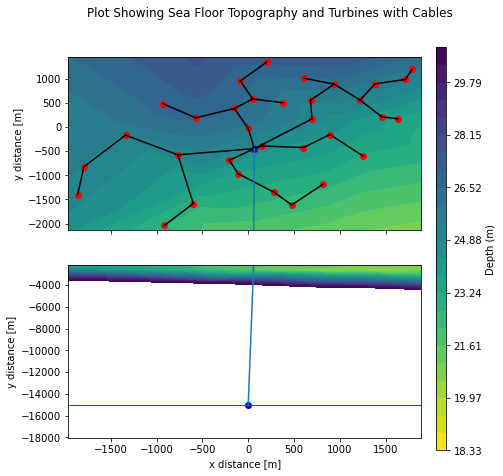

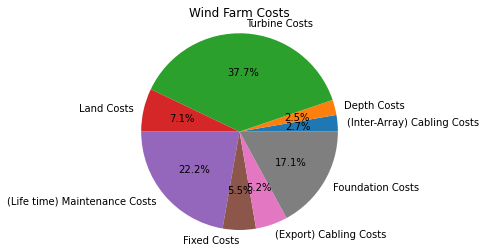

In [209]:
## GUASSIAN LAYOUT AND GAUSSIAN TESTING
## INPUTS (DO NOT OVERWRITE): smallestpositionlist, smallestindiceslist, OptimizedTPO, smallestTotalCost
## Calculates results for the optimised positionlist
distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)
print(f'positionlist[1:,:].shape = {positionlist[1:,:].shape}\n angles.shape = {angles.shape}')
## Below calculates max theoreticl power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)

## Displays imported optimised layout
print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (GAUSSIAN LAYOUT & TESTING)'+'\033[0m'+'\033[0m')
print()
OptimizedTPO = smallestTotalCost/smallestCostPerWatt
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data,OnshoreSubstation,smallestExportDistance)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(OptimizedTPO,smallestTotalCost,smallestpositionlist)
print('\033[1m'+'Total Power Output:'+'\033[0m', OptimizedTPO, 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(OptimizedTPO/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [213]:
## SAVE VARIABLE TO FILE FOR USE IN OTHER CODE
import pickle

optimised_farm_variables = {'smallestpositionlist': smallestpositionlist, 'smallestindiceslist': smallestindiceslist, 'OptimizedTPO': OptimizedTPO, 'smallestTotalCost': smallestTotalCost, 'smallestCostPerWatt': smallestCostPerWatt, 'smallestExportDistance': smallestExportDistance, 'MSTWeightSum':MSTWeightSum}
with open('optimised_farm_variables.pkl', 'wb') as f:
    pickle.dump(optimised_farm_variables, f)

In [210]:
# ## IMPORTED LAYOUT AND GAUSSIAN TESTING
# ## note: only valid for the same parameters as the code that generated this layout
# ## IMPORT ATTENUATION LAYOUT
# dang = 10;
# windangle = 10;
# import pickle
# with open('optimised_farm_variables.pkl', 'rb') as f:
#     my_variables = pickle.load(f)
# PositionList_imported = my_variables['smallestpositionlist'] ## valid import
# IndicesList_imported = my_variables['smallestindiceslist'] ## valid import
# ExportDistance_imported = my_variables['smallestExportDistance'] ## valid import
# MSTWeightSum_imported = my_variables['MSTWeightSum'] ## valid import (total length of cabling)(this import breaks the idea of a position only import, but I don't understand the MST rn)

# ## Calculates various financial data relating to the position list imported
# OnshoreSubstation,ExportDistance_exp = Substation_To_Shore_Connection(PositionList_imported)
# FoundationCostTotal_exp = foundations(PositionList_imported)
# ExportCableCost_exp = (ExportDistance_imported*ExportCableCostperMeter) # Export cable cost
# FixedCost_exp = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
# CableCost_exp = (MSTWeightSum_imported/1000)*IACableCostperMeter
# DepthCostAll_exp = depthvalues(PositionList_imported)[0]
# TurbineCostTotal_exp = (nturb)*CostperTurbine
# MaintenanceCosts_exp = (nturb)*MaintenanceCostperTurbine
# LandCost_exp = LandAreaCost(PositionList_imported,ExportDistance_imported)
# TotalCost_exp = TurbineCostTotal_exp+DepthCostAll_exp+MaintenanceCosts_exp+FixedCost_exp+LandCost_exp+CableCost_exp+ExportCableCost_exp+FoundationCostTotal_exp

# ## Calculates results for the imported optimised positionlist
# distance_exp,angle,distance_global,angle_global = geom_analysis(PositionList_imported,IndicesList_imported)
# MSTweight = Minimum_Spanning_Tree(distance_exp,IndicesList_imported)
# wsr_exp = windspeedreduction(PositionList_imported[1:,:],angles,predict_class)
# powout_exp = power(wsr_exp,velocities) # total output power
# output_exp = np.tensordot(powout_exp,wsp,axes=2)
# TotalPower_exp = np.sum(output_exp)
# CostPerWatt_exp = TotalCost_exp/TotalPower_exp

# ## Below calculates max theoretical power output
# wsr_noWake = np.multiply(0.92477772, np.ones(wsr_exp.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
# powout_noWake = power(wsr_noWake,velocities)
# output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
# TotalPower_noWake = np.sum(output_noWake)

# ## Displays imported optimised layout
# print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (IMPORTED LAYOUT W/ GAUSSIAN TESTING)'+'\033[0m'+'\033[0m')
# print()
# plotting_function(PositionList_imported,IndicesList_imported,MSTweight,data,OnshoreSubstation,ExportDistance_imported)
# OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(TotalPower_exp,TotalCost_exp,PositionList_imported)
# print('\033[1m'+'Total Power Output:'+'\033[0m', TotalPower_exp, 'W')
# print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', TotalPower_noWake, 'W')
# print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(TotalPower_exp/TotalPower_noWake))*100, '%')
# print('\033[1m'+'Cost per Watt'+'\033[0m',CostPerWatt_exp,'£/W')
# print('')
# print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
# print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
# print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
# print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [211]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.

In [212]:
print(res.success) # whether the minization was succesful or not
print(res.status) # termination status
print(res.message) # Description of the cause of termination
print(res.nit) # number of iterations performed by the optimizer

True
0
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
18
